# Feux de forêt

Projet Python de 2A à l'ENSAE portant sur l'étude des feux de forêt en France.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import urllib
import os
from datetime import datetime

C:\Users\theoc\anaconda3\envs\ML\lib\site-packages\geopandas\_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


# I. Récupération et traitement des données

On récupère les données sur le site de Météo-France. Les données disponibles complètes sur l'année sont de 1997 à 2019.
https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32

Voici notre fonction pour télécharger les données :

In [2]:
def download_data_meteo():
    
    for k in range(1997,2020):
        for i in range(1,13):

            if i <= 9:
                month = '0' + str(i)
            else:
                month = str(i)

            file_date = str(k) + month
            file_url = 'https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/Archive/synop.' + file_date + '.csv.gz'
            output_file_name = file_date + '.csv.gz'

            if os.path.exists('bdd_meteo') == 0:
                os.mkdir('bdd_meteo') 

            urllib.request.urlretrieve (file_url, 'bdd_meteo/' + output_file_name)
    
    return 'Téléchargement terminé !'    

Test d'un fichier en ouverture :

In [3]:
pd.read_csv('bdd_meteo/200202.csv.gz', sep = ';')

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,Unnamed: 59
0,7005,20020201000000,101540,20,3,210,7.200000,281.850000,280.650000,92,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
1,7015,20020201000000,101520,-20,5,200,8.700000,281.450000,279.450000,87,...,7,3,3000,mq,mq,mq,mq,mq,mq,NaN
2,7020,20020201000000,101500,180,2,220,9.800000,283.650000,283.050000,96,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
3,7027,20020201000000,101770,380,1,240,5.100000,282.450000,280.550000,88,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
4,7037,20020201000000,101690,10,3,250,8.200000,282.450000,281.850000,96,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12891,78922,20020228210000,101350,-70,5,80,4.100000,298.750000,290.650000,61,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
12892,81401,20020228210000,100980,mq,mq,50,5.100000,300.750000,296.350000,77,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
12893,81405,20020228210000,100970,mq,mq,70,4.100000,299.750000,297.050000,85,...,4,8,660,5,3,3000,mq,mq,mq,NaN
12894,81415,20020228210000,100960,mq,mq,mq,mq,298.150000,296.950000,93,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN


Nous voyons que les fichiers bruts ont énormément de colonnes avec des noms peu clairs. Il y a également beaucoup de NaN (ici 'mq') que nous devrons traiter.

Voici la fonction pour traiter un fichier :

In [4]:
def cleaned_csv_meteo(year, month):
    
    if month <= 9:
        file = 'bdd_meteo/' + str(year) + '0' + str(month) + '.csv.gz'
    
    else:
        file = 'bdd_meteo/' + str(year) + str(month) + '.csv.gz'
        
    #ouvrir le fichier   
    df_file = pd.read_csv(file, sep=';')
    
    #sélectionner et renommer les colonnes
    df_file = df_file.rename(columns={'numer_sta':'Station', 'date':'Date', 't':'Température (°C)', 'rr3':'Précipitations (3 heures)', 'u':'Humidité (%)', 'ff':'Vitesse du vent (m/s)'})
    df_file = df_file[['Station', 'Date', 'Température (°C)', 'Précipitations (3 heures)', 'Humidité (%)', 'Vitesse du vent (m/s)']]
    
    #modifier le format de la date et l'heure
    df_file['Date'] = df_file['Date'].apply(lambda x: datetime(year = int(str(x)[0:4]), month = int(str(x)[4:6]), day = int(str(x)[6:8]), hour = int(str(x)[8:10])))
    
    #convertir les Kelvin en degrés Celsius
    l = list(df_file['Température (°C)'])
    for i in range(len(l)):
        if l[i] != 'mq':
            df_file.loc[i, 'Température (°C)'] = float(l[i]) - 273.15
    
    #trier par station et date ainsi que reset l'index
    df_file = df_file.sort_values(['Station', 'Date']).reset_index(drop = True)
    
    return df_file

Voici un exemple du résultat :

In [5]:
cleaned_csv_meteo(2002,2)

,Station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,7005,2002-02-01 00:00:00,8.7,0.800000,92,7.200000
1,7005,2002-02-01 03:00:00,9,0.000000,90,6.200000
2,7005,2002-02-01 06:00:00,9.1,mq,86,6.200000
3,7005,2002-02-01 09:00:00,11.1,0.200000,88,8.200000
4,7005,2002-02-01 12:00:00,13.3,mq,78,10.800000
...,...,...,...,...,...,...
12891,89642,2002-02-28 09:00:00,-7.8,mq,52,8.700000
12892,89642,2002-02-28 12:00:00,-8.4,mq,50,13.900000
12893,89642,2002-02-28 15:00:00,-7.4,mq,56,9.800000
12894,89642,2002-02-28 18:00:00,-7.7,mq,75,15.900000


Il ne reste plus qu'à regrouper tous les fichiers mensuels en un seul dataframe :

In [6]:
def concat_meteo(year_begin, year_end):
    
    df_meteo = pd.DataFrame()

    for k in range(year_begin, year_end + 1):
        for i in range(1,13):       
            df_meteo = pd.concat([df_meteo, cleaned_csv_meteo(k,i)], ignore_index = True)

    return df_meteo

In [1]:
#lignes de commande pour enregistrer le fichier 'data_meteo.csv'
#df_meteo = concat_meteo(2006,2019)
#df_meteo.to_csv('data_meteo.csv', index = False)

In [8]:
df_meteo = pd.read_csv('data_meteo_2ans.csv')
df_meteo

,Station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,7005,2017-01-01 00:00:00,-3.8999999999999773,0.000000,96,0.000000
1,7005,2017-01-01 03:00:00,-5.099999999999966,0.000000,94,0.000000
2,7005,2017-01-01 06:00:00,-4.099999999999966,0.000000,96,0.000000
3,7005,2017-01-01 09:00:00,-2.1999999999999886,0.000000,97,0.000000
4,7005,2017-01-01 12:00:00,-0.8999999999999773,0.000000,98,0.000000
...,...,...,...,...,...,...
331919,89642,2018-12-31 09:00:00,-1.3999999999999773,mq,65,20.100000
331920,89642,2018-12-31 12:00:00,-2.2999999999999545,mq,71,21.600000
331921,89642,2018-12-31 15:00:00,-1.5,mq,64,20.100000
331922,89642,2018-12-31 18:00:00,-2.3999999999999773,mq,72,20.100000


**On va désormais relier les stations météos à une position sur la carte de France**

Les fichiers 'postesSynop.txt' et 'postesSynop.json' ont été trouvés sur le site de Météo-France. Ils comportent les caractéristiques des stations météo.

In [9]:
stations = pd.read_csv('postesSynop.txt', sep = ';')
stations

,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136000,1.834000,69
1,7015,LILLE-LESQUIN,50.570000,3.097500,47
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67
4,7037,ROUEN-BOOS,49.383000,1.181667,151
...,...,...,...,...,...
57,81401,SAINT LAURENT,5.485500,-54.031667,5
58,81405,CAYENNE-MATOURY,4.822333,-52.365333,4
59,81408,SAINT GEORGES,3.890667,-51.804667,6
60,81415,MARIPASOULA,3.640167,-54.028333,106


In [10]:
stations_geo = gpd.read_file('postesSynop.json')
stations_geo

,ID,Nom,Latitude,Longitude,Altitude,geometry
0,07005,ABBEVILLE,50.136000,1.834000,69,POINT (1.83400 50.13600)
1,07015,LILLE-LESQUIN,50.570000,3.097500,47,POINT (3.09750 50.57000)
2,07020,PTE DE LA HAGUE,49.725167,-1.939833,6,POINT (-1.93983 49.72517)
3,07027,CAEN-CARPIQUET,49.180000,-0.456167,67,POINT (-0.45617 49.18000)
4,07037,ROUEN-BOOS,49.383000,1.181667,151,POINT (1.18167 49.38300)
...,...,...,...,...,...,...
57,81401,SAINT LAURENT,5.485500,-54.031667,5,POINT (-54.03167 5.48550)
58,81405,CAYENNE-MATOURY,4.822333,-52.365333,4,POINT (-52.36533 4.82233)
59,81408,SAINT GEORGES,3.890667,-51.804667,6,POINT (-51.80467 3.89067)
60,81415,MARIPASOULA,3.640167,-54.028333,106,POINT (-54.02833 3.64017)


On utilise également la base de données des villes françaises. On traite ces données pour obtenir seulement les informations dont on a besoin. On traite aussi le texte en enlevant les tirets et slash.

In [11]:
villes = pd.read_csv('villes_france.csv',sep=',', low_memory=False)
villes = villes.iloc[:, [1,3,8,19,20]]
villes.columns = ['Département', 'Nom', 'Code postal', 'Longitude', 'Latitude']
villes['Nom'] = villes['Nom'].str.replace('-', ' ')
villes['Nom'] = villes['Nom'].str.replace('\'', ' ')

villes

,Département,Nom,Code postal,Longitude,Latitude
0,01,CORMORANCHE SUR SAONE,01290,4.83333,46.23330
1,01,PLAGNE,01130,5.73333,46.18330
2,01,TOSSIAT,01250,5.31667,46.13330
3,01,POUILLAT,01250,5.43333,46.33330
4,01,TORCIEU,01230,5.40000,45.91670
...,...,...,...,...,...
36694,976,SADA,97640,45.10470,-12.84860
36695,976,TSINGONI,97680,45.10700,-12.78970
36696,971,SAINT BARTHELEMY,97133,-62.83330,17.91670
36697,971,SAINT MARTIN,97150,18.09130,-63.08290


On utilise la base de données BDIFF pour les feux de forêt
https://bdiff.agriculture.gouv.fr/incendies

In [12]:
df_feu = pd.read_csv('BDIFF.csv', sep = ';', skiprows = [0,1])
df_feu

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Statut
0,2019,14,46,46085,CUZAC,2019-02-15 18:50:00,4000,0,4000,0.0,0.0,0,Estimées,Validé
1,2019,15,46,46043,CAHUS,2019-02-17 12:09:00,300,0,300,0.0,0.0,0,Estimées,Validé
2,2019,16,38,38140,CROLLES,2019-02-15 13:55:00,140000,140000,0,0.0,0.0,0,Mesurées,Validé
3,2019,17,46,46083,CRESSENSAC SARRAZAC,2019-02-20 14:10:00,2000,0,2000,0.0,0.0,0,Estimées,Validé
4,2019,19,81,81007,ALOS,2019-02-25 15:31:00,5300,0,5300,0.0,0.0,0,Estimées,Validé
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2902,2019,5755,2B,2B183,OGLIASTRO,2019-01-03 16:40:00,1500,1500,0,NaN,NaN,0,NaN,Validé
2903,2019,5756,2B,2B235,PIOGGIOLA,2019-01-02 14:35:00,8000,8000,0,NaN,NaN,0,NaN,Validé
2904,2019,5757,06,06074,LANTOSQUE,2019-01-05 16:10:00,5000,5000,0,NaN,NaN,0,NaN,Validé
2905,2019,5758,34,34130,LAURENS,2019-01-06 17:11:00,1326,1326,0,NaN,NaN,0,NaN,Validé


**Fusion feu/liste des villes**

Il n'y a pas de code INSEE pour la bdd des villes et pas de code postal pour la bdd des feux. Le nom de commune ne suffit pas car il y a des homonymes. On crée donc une colomne avec le nom de commune + le numéro de département pour la fusion. 

In [13]:
villes['Clé'] = villes['Département'] + villes['Nom']
villes = villes.drop(columns = ['Département', 'Nom'])
df_feu['Clé'] = df_feu['Département'] + df_feu['Commune']

In [14]:
#jointure feu/ville

df_feu_villes = pd.merge(df_feu, villes, on = 'Clé', how ='inner')
df_feu_villes = df_feu_villes.drop(columns = 'Clé')
df_feu_villes

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Statut,Code postal,Longitude,Latitude
0,2019,14,46,46085,CUZAC,2019-02-15 18:50:00,4000,0,4000,0.0,0.0,0,Estimées,Validé,46270,2.15000,44.5833
1,2019,15,46,46043,CAHUS,2019-02-17 12:09:00,300,0,300,0.0,0.0,0,Estimées,Validé,46130,1.93333,44.9500
2,2019,16,38,38140,CROLLES,2019-02-15 13:55:00,140000,140000,0,0.0,0.0,0,Mesurées,Validé,38190,5.88333,45.2833
3,2019,19,81,81007,ALOS,2019-02-25 15:31:00,5300,0,5300,0.0,0.0,0,Estimées,Validé,81140,1.88333,44.0167
4,2019,30,39,39306,MACORNAY,2019-02-27 12:35:00,15000,15000,0,0.0,0.0,0,Estimées,Validé,39570,5.53333,46.6500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,2019,5745,06,06098,PUGET ROSTANG,2019-01-13 16:45:00,30000,0,20000,NaN,NaN,10000,NaN,Validé,06260,6.91667,43.9667
2642,2019,5746,2B,2B150,LUMIO,2019-01-12 15:26:00,300,300,0,NaN,NaN,0,NaN,Validé,20260,8.83334,42.5784
2643,2019,5750,06,06066,GILETTE,2019-01-11 21:16:00,20000,20000,0,NaN,NaN,0,NaN,Validé,06830,7.16667,43.8500
2644,2019,5754,2B,2B364,ZUANI,2019-01-04 10:55:00,1500,1500,0,NaN,NaN,0,NaN,Validé,20272,9.34640,42.2714


On voit qu'on perd des lignes car certains feux ont des NaN dans la colonne 'Commune'

In [15]:
stations

,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136000,1.834000,69
1,7015,LILLE-LESQUIN,50.570000,3.097500,47
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67
4,7037,ROUEN-BOOS,49.383000,1.181667,151
...,...,...,...,...,...
57,81401,SAINT LAURENT,5.485500,-54.031667,5
58,81405,CAYENNE-MATOURY,4.822333,-52.365333,4
59,81408,SAINT GEORGES,3.890667,-51.804667,6
60,81415,MARIPASOULA,3.640167,-54.028333,106


Calcul de la distance entre chaque commune de df_feu_villes et chaque station pour trouver la plus proche :

In [16]:
import geopy.distance

In [17]:
def distance(lat1, long1, lat2, long2):
    
    coords_1 = (lat1, long1)
    coords_2 = (lat2, long2)
    
    return(geopy.distance.distance(coords_1, coords_2).km)

In [18]:
def station_la_plus_proche(codeinsee):
    
    sub = df_feu_villes[df_feu_villes['Code INSEE'] == codeinsee]
    L_dist = []
    lat = sub['Latitude'].iloc[0]
    long = sub['Longitude'].iloc[0]
    
    if long is not None and lat is not None:        
        for k in range(stations.shape[0]):
            L_dist.append(distance(lat, long, stations.loc[k, 'Latitude'], stations.loc[k, 'Longitude']))
            
        return stations.iloc[L_dist.index(min(L_dist)), 1]
    
    else: 
        return None 

In [19]:
df_feu_villes['Station la plus proche'] = df_feu_villes['Code INSEE'].apply(lambda row: station_la_plus_proche(row))
df_feu_villes

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Statut,Code postal,Longitude,Latitude,Station la plus proche
0,2019,14,46,46085,CUZAC,2019-02-15 18:50:00,4000,0,4000,0.0,0.0,0,Estimées,Validé,46270,2.15000,44.5833,GOURDON
1,2019,15,46,46043,CAHUS,2019-02-17 12:09:00,300,0,300,0.0,0.0,0,Estimées,Validé,46130,1.93333,44.9500,GOURDON
2,2019,16,38,38140,CROLLES,2019-02-15 13:55:00,140000,140000,0,0.0,0.0,0,Mesurées,Validé,38190,5.88333,45.2833,LYON-ST EXUPERY
3,2019,19,81,81007,ALOS,2019-02-25 15:31:00,5300,0,5300,0.0,0.0,0,Estimées,Validé,81140,1.88333,44.0167,TOULOUSE-BLAGNAC
4,2019,30,39,39306,MACORNAY,2019-02-27 12:35:00,15000,15000,0,0.0,0.0,0,Estimées,Validé,39570,5.53333,46.6500,DIJON-LONGVIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,2019,5745,06,06098,PUGET ROSTANG,2019-01-13 16:45:00,30000,0,20000,NaN,NaN,10000,NaN,Validé,06260,6.91667,43.9667,NICE
2642,2019,5746,2B,2B150,LUMIO,2019-01-12 15:26:00,300,300,0,NaN,NaN,0,NaN,Validé,20260,8.83334,42.5784,BASTIA
2643,2019,5750,06,06066,GILETTE,2019-01-11 21:16:00,20000,20000,0,NaN,NaN,0,NaN,Validé,06830,7.16667,43.8500,NICE
2644,2019,5754,2B,2B364,ZUANI,2019-01-04 10:55:00,1500,1500,0,NaN,NaN,0,NaN,Validé,20272,9.34640,42.2714,BASTIA


In [20]:
df_final = pd.merge(df_feu_villes, stations, how = 'inner', left_on = 'Station la plus proche', right_on = 'Nom')
df_final = df_final.drop(columns = 'Nom')
df_final=df_final.rename(columns={"Longitude_x": "Longitude commune", 
                                  "Latitude_x": "Latitude commune", "ID": "id_station", "Latitude_y": "Latitude station", 
                                  "Longitude_y": "Longitude station", "Altitude": "Altitude station"})
df_final

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),...,Précision des surfaces,Statut,Code postal,Longitude commune,Latitude commune,Station la plus proche,id_station,Latitude station,Longitude station,Altitude station
0,2019,14,46,46085,CUZAC,2019-02-15 18:50:00,4000,0,4000,0.0,...,Estimées,Validé,46270,2.15000,44.5833,GOURDON,7535,44.745000,1.396667,260
1,2019,15,46,46043,CAHUS,2019-02-17 12:09:00,300,0,300,0.0,...,Estimées,Validé,46130,1.93333,44.9500,GOURDON,7535,44.745000,1.396667,260
2,2019,38,46,46282,SAINT MEDARD NICOURBY,2019-02-22 19:12:00,10000,0,10000,0.0,...,Estimées,Validé,46210,2.05000,44.7667,GOURDON,7535,44.745000,1.396667,260
3,2019,40,46,46249,SAINT BRESSOU,2019-02-25 16:20:00,2000,0,2000,0.0,...,Estimées,Validé,46120,1.98333,44.7000,GOURDON,7535,44.745000,1.396667,260
4,2019,41,46,46087,DEGAGNAC,2019-02-25 17:50:00,5000,0,5000,0.0,...,Estimées,Validé,46340,1.31667,44.6667,GOURDON,7535,44.745000,1.396667,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,2019,5737,2B,2B257,RAPALE,2019-01-14 17:16:00,500,500,0,NaN,...,NaN,Validé,20246,9.30362,42.5909,BASTIA,7790,42.540667,9.485167,10
2642,2019,5738,2B,2B015,AMPRIANI,2019-01-14 14:46:00,2000,2000,0,NaN,...,NaN,Validé,20272,9.35723,42.2542,BASTIA,7790,42.540667,9.485167,10
2643,2019,5746,2B,2B150,LUMIO,2019-01-12 15:26:00,300,300,0,NaN,...,NaN,Validé,20260,8.83334,42.5784,BASTIA,7790,42.540667,9.485167,10
2644,2019,5754,2B,2B364,ZUANI,2019-01-04 10:55:00,1500,1500,0,NaN,...,NaN,Validé,20272,9.34640,42.2714,BASTIA,7790,42.540667,9.485167,10


**Obtention du fond de carte des communes:**

In [21]:
import requests
import tempfile
import zipfile

temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
    myfile = requests.get(url)
    open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
        zip_ref.extractall(dirname + '/' + destname)

In [22]:
download_unzip("https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12")
communes_borders = gpd.read_file(temporary_location + "/borders/communes-20190101.json")
communes_borders.head()

,insee,nom,wikipedia,surf_ha,geometry
0,97223,Saint-Esprit,fr:Saint-Esprit (Martinique),2318,"POLYGON ((-60.93595 14.58812, -60.93218 14.585..."
1,97233,Le Morne-Vert,fr:Le Morne-Vert,1325,"POLYGON ((-61.12165 14.71928, -61.11852 14.716..."
2,97208,Fonds-Saint-Denis,fr:Fonds-Saint-Denis,2374,"POLYGON ((-61.13355 14.74657, -61.13066 14.748..."
3,97224,Saint-Joseph,fr:Saint-Joseph (Martinique),4324,"POLYGON ((-61.08459 14.72510, -61.08430 14.722..."
4,97212,Gros-Morne,fr:Gros-Morne,4601,"POLYGON ((-61.08459 14.72510, -61.08061 14.725..."


In [23]:
communes_borders['dep'] = communes_borders['insee'].str[:2]

<AxesSubplot:>

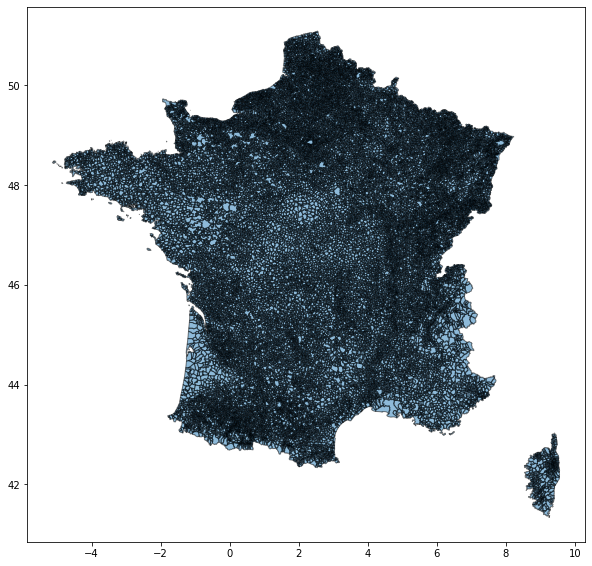

In [24]:
france = communes_borders[communes_borders['dep'] != '97']
fr = france.plot(figsize = (10, 10), alpha = 0.5, edgecolor = 'k')
fr

<AxesSubplot:>

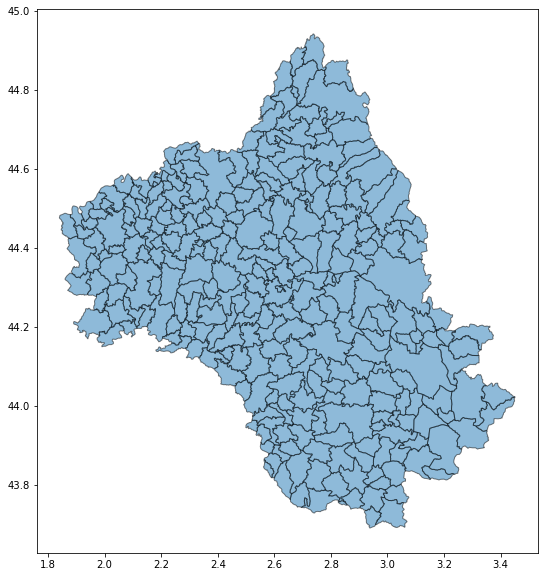

In [25]:
aveyron = communes_borders[communes_borders.insee.str.startswith("12")]
av = aveyron.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
av